### Import packages

In [7]:
import sys
sys.path
sys.path.append("/anaconda3/envs/metis/lib/python3.7/site-packages")

%pylab inline
%config InlineBackend.figure_formats = ['retina']

from collections import OrderedDict
from collections import Counter

from statistics import mean
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold

Populating the interactive namespace from numpy and matplotlib


In [8]:
sys.path.append("/anaconda3/envs/metis/lib/python3.6/site-packages")
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

from mlxtend.plotting import plot_decision_regions #plotting regions

Using TensorFlow backend.
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


### Read and clean data

In [9]:
df_2017 = pd.read_csv('usa_00006.csv')

In [10]:
df_2017.columns

Index(['YEAR', 'DATANUM', 'SERIAL', 'CBSERIAL', 'HHWT', 'STATEFIP', 'METRO',
       'CITY', 'GQ', 'OWNERSHP', 'OWNERSHPD', 'PERNUM', 'PERWT', 'NCHILD',
       'SEX', 'AGE', 'MARST', 'BPL', 'BPLD', 'HCOVANY', 'EDUC', 'EDUCD',
       'EMPSTAT', 'EMPSTATD', 'OCC', 'IND', 'POVERTY', 'MIGRATE1',
       'MIGRATE1D'],
      dtype='object')

In [11]:
# Filter for adults only:
df = df_2017.loc[(df_2017.AGE >= 18),:].copy()

# Generate unique identifier for each person
df['UNIQUE_ID'] = df['YEAR'].map(str) + df['DATANUM'].map(str) + \
                     df['SERIAL'].map(str) + df['PERNUM'].map(str)

# Set poverty binary (less than 100% of poverty level is 1)
df['POVERTY_BIN'] = np.where(df['POVERTY'] <= 100, 1,0)

# Keep only relevant columns
model_cols = ['UNIQUE_ID', 'PERWT', 'POVERTY_BIN', 'AGE', 'MIGRATE1', 'NCHILD', 'BPL', \
              'EDUC', 'MARST', 'EMPSTAT', 'SEX', 'HCOVANY']

df_M = df[model_cols].copy()

# Set 0's to nulls
null_cols = ['MIGRATE1', 'EDUC', 'EMPSTAT']

df_M.loc[:, null_cols] = df_M.loc[:, null_cols].replace({0:np.nan})

# Drop nulls
df_M = df_M.dropna()

In [12]:
print('Original shape:', df.shape)
print('Post clean shape:', df_M.shape)

Original shape: (2530726, 31)
Post clean shape: (2494864, 12)


In [13]:
# Generate international migration binary
df_M['MIGRATE_BIN'] = np.where(df_M['MIGRATE1'] == 4, 1,0)

# Generate born within the US binary
df_M['BPL_BIN'] = np.where(df_M['BPL'] <= 120, 1,0)

# Generate marriage binary (currently married = 1, not ever married or divorced = 0)
df_M['MARST_BIN'] = np.where(df_M['MARST'] <= 2, 1,0)

# Generate education bins (middle school only, high school only, 4 years college, 4+ years college)
educ_bins = [0, 2, 6, 10, 11]
educ_labels = ['LOW_ED', 'HIGH_SCH_ED', 'UNDERGRAD_ED', 'GRAD_ED']

df_M['EDUC_CAT'] = pd.cut(df_M['EDUC'], educ_bins, labels = educ_labels, include_lowest = True)

# Generate employment bins
df_M.loc[df_M['EMPSTAT'] == 1, 'EMPSTAT'] = 'EMPLOYED'
df_M.loc[df_M['EMPSTAT'] == 2, 'EMPSTAT'] = 'UNEMPLOYED'
df_M.loc[df_M['EMPSTAT'] == 3, 'EMPSTAT'] = 'N_LABOR'

# Generate gender binary
df_M['SEX'] = np.where(df_M['SEX'] == 2, 'MALE', 'FEMALE')

# Generate health coverage binary
df_M['HCOVANY'] = np.where(df_M['HCOVANY'] == 2, 1, 0)

df_M = pd.get_dummies(df_M, columns = ['EDUC_CAT', 'EMPSTAT', 'SEX'], drop_first = True).reset_index()

In [14]:
df_M.head()

,index,UNIQUE_ID,PERWT,POVERTY_BIN,AGE,MIGRATE1,NCHILD,BPL,EDUC,MARST,HCOVANY,MIGRATE_BIN,BPL_BIN,MARST_BIN,EDUC_CAT_HIGH_SCH_ED,EDUC_CAT_UNDERGRAD_ED,EDUC_CAT_GRAD_ED,EMPSTAT_N_LABOR,EMPSTAT_UNEMPLOYED,SEX_MALE
0,0,2017111,206,1,73,1.0,0,1,2.0,3,1,0,1,0,0,0,0,1,0,0
1,1,2017121,45,0,31,1.0,0,13,10.0,6,1,0,1,0,0,1,0,0,0,1
2,2,2017131,136,0,41,1.0,1,13,6.0,1,1,0,1,1,1,0,0,0,0,0
3,3,2017132,121,0,48,1.0,1,17,6.0,1,1,0,1,1,1,0,0,1,0,1
4,5,2017141,18,1,37,1.0,4,1,6.0,4,1,0,1,0,1,0,0,0,0,1


0    0.848712
1    0.151288
Name: POVERTY_BIN, dtype: float64


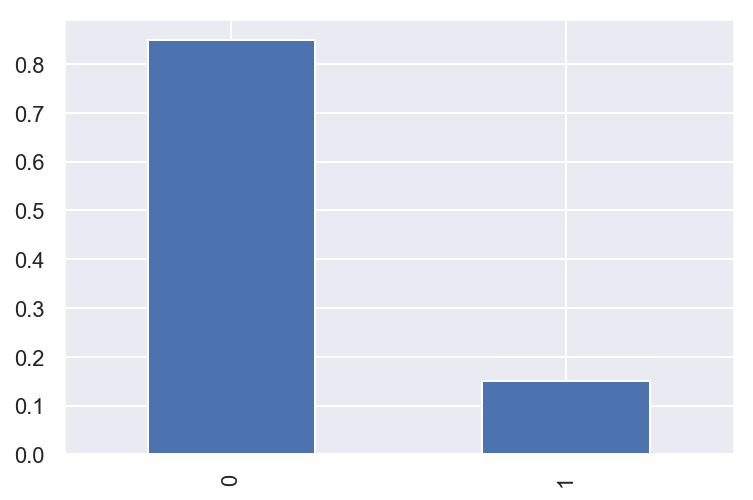

In [15]:
# Visualize % in poverty for overall data
target_pcts = df_M['POVERTY_BIN'].value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar');

/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


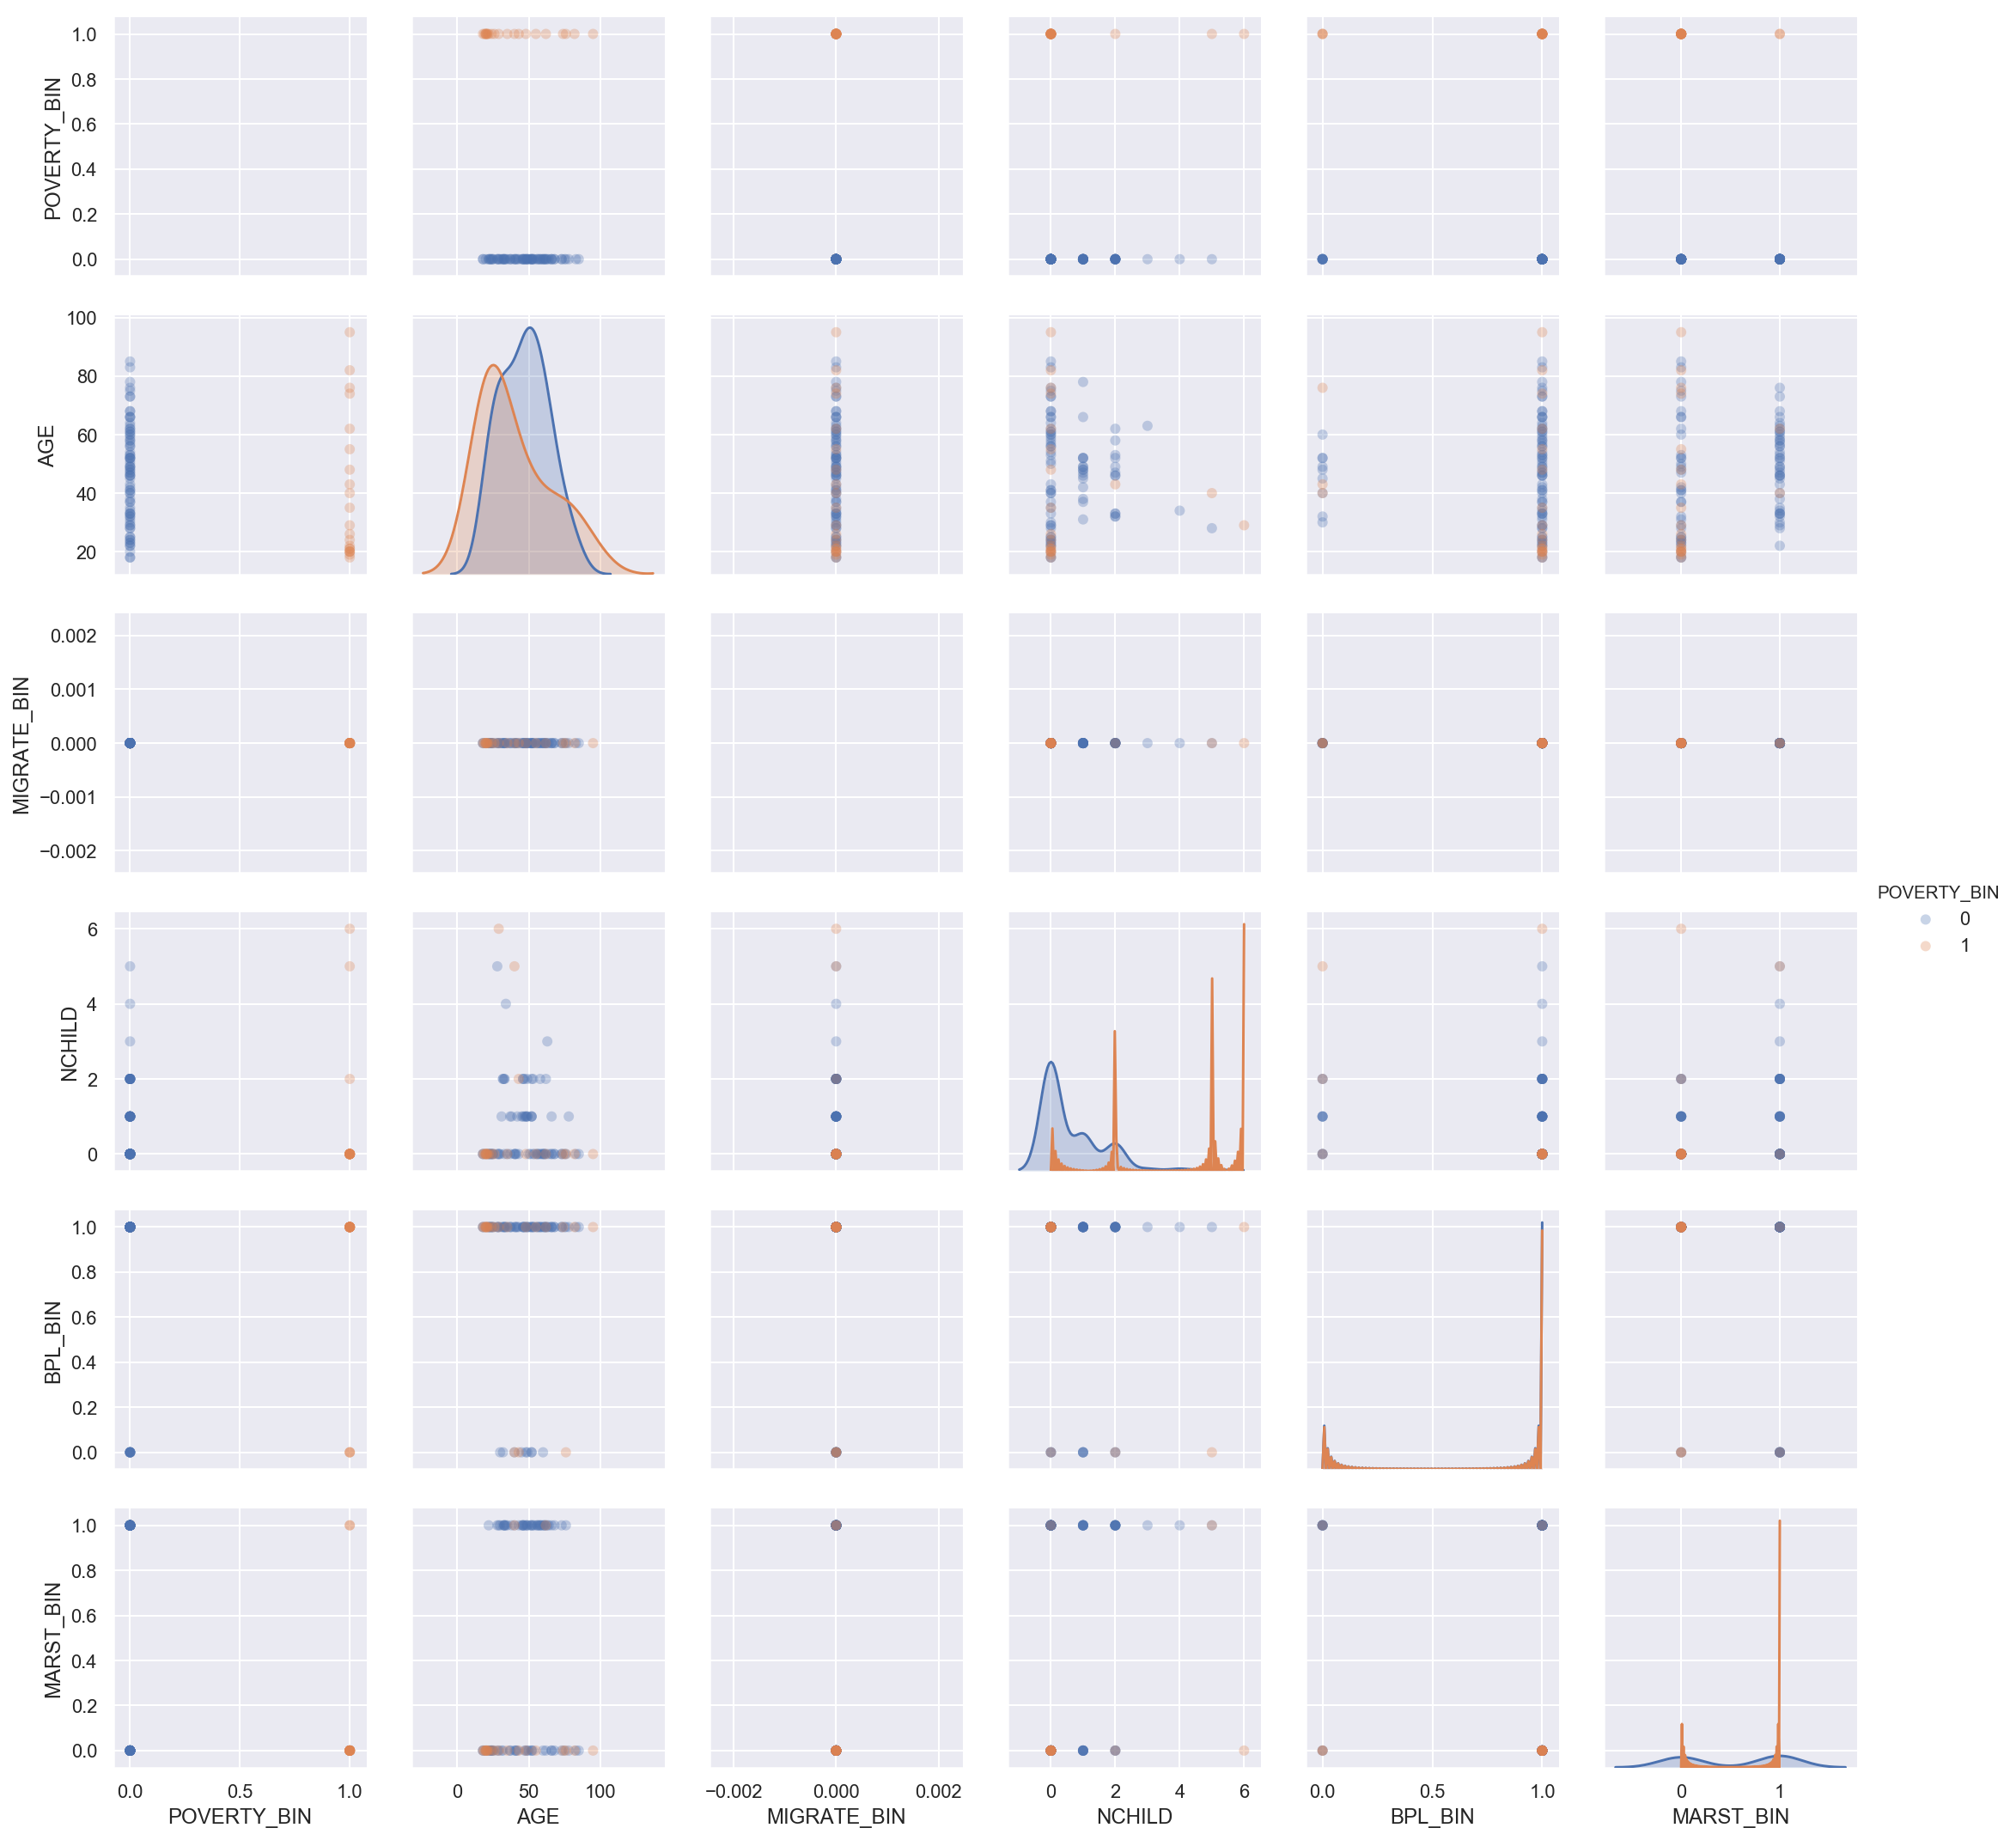

In [16]:
plot_cols = ['POVERTY_BIN', 'AGE', 'MIGRATE_BIN', 'NCHILD', 'BPL_BIN', \
             'MARST_BIN']

def plot_features(df, sample_size=500):
    
    sample = (df[plot_cols]
                .sample(100, random_state=20)) 
    
    sns.pairplot(sample,hue='POVERTY_BIN', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_M)

### Testing Helper Functions

In [17]:
def scores(model, X_te, y_te, threshold):
    prediction = model.predict_proba(X_te)[:,1] > threshold 
    print(classification_report(y_te, prediction, digits = 4))

In [18]:
def print_ROC_curve(model, X_te, y_te):
    fpr, tpr, thresholds = roc_curve(y_te, model.predict_proba(X_te)[:,1])
    
    plt.plot(fpr, tpr,lw=2)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(f'ROC curve for {model} model');
    print("ROC AUC score = ", roc_auc_score(y_te, model.predict_proba(X_te)[:,1]))

In [19]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (9,5), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### Test Split Data

In [105]:
# X = df_M[['AGE', 'MIGRATE_BIN', 'NCHILD', 'BPL_BIN', 'MARST_BIN', \
#              'EDUC_CAT_HIGH_SCH_ED', 'EDUC_CAT_UNDERGRAD_ED', 'EDUC_CAT_GRAD_ED', 'PERWT', \
#              'EMPSTAT_N_LABOR', 'EMPSTAT_UNEMPLOYED', 'SEX_MALE', 'HCOVANY']]
X = df_M.drop(['UNIQUE_ID', 'MIGRATE1', 'POVERTY_BIN', 'BPL', 'EDUC', 'MARST'], axis = 1)
y = df_M[['POVERTY_BIN']]
X_init, X_te, y_init, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [109]:
std = StandardScaler()

# Scale the 
X_init_sc = X_init.copy()
X_scale_cols = X_init.drop(['PERWT'], axis = 1)
scaler = std.fit_transform(X_scale_cols.values)
X_init_sc.loc[:,list(X_scale_cols.columns)] = scaler

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [116]:
#run the CV
def run_CV(model, X_init, y_init):
    
    scores=[]
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 42)

    for train_ind, val_ind in kf.split(X_init,y_init):

        X_tr, y_tr = X_init.iloc[train_ind,:], y_init.iloc[train_ind,:]
        X_val, y_val = X_init.iloc[val_ind,:], y_init.iloc[val_ind,:]
        
        WT_tr = X_tr[['PERWT']].copy()
        
        X_tr = X_tr.drop(columns = ['PERWT', 'index'])
        X_val = X_val.drop(columns = ['PERWT', 'index'])
        
        model.fit(X_tr, y_tr.values.ravel(), sample_weight = WT_tr.values.ravel())
        y_pred = model.predict(X_val)
        
        scores.append(precision_score(y_val, y_pred))
    
    print(1)
    
    return scores

### Logistic Regression CV

In [24]:
lrCV = LogisticRegressionCV(scoring = 'precision', max_iter = 500, cv = 5, 
                            class_weight = 'balanced', random_state = 42)
lrCV_fit = lrCV.fit(X_init_sc, y_init.values.ravel(), sample_weight = WT_init.values.ravel())

In [25]:
lrCV.scores_

{1: array([[0.37491972, 0.37489153, 0.37487309, 0.3748861 , 0.37487634,
         0.3748861 , 0.37487634, 0.3748861 , 0.37489153, 0.37489153],
        [0.37536739, 0.37538263, 0.37537281, 0.37538263, 0.37538153,
         0.37538263, 0.3753837 , 0.37537936, 0.37538263, 0.37537608],
        [0.37611449, 0.37606532, 0.37606637, 0.37608059, 0.37606964,
         0.37607731, 0.37606637, 0.3760762 , 0.37608275, 0.37607292],
        [0.3769133 , 0.3768902 , 0.37687922, 0.3768902 , 0.37687379,
         0.37688692, 0.37688035, 0.3768989 , 0.37689676, 0.3768902 ],
        [0.37200598, 0.37199091, 0.37198769, 0.37198769, 0.37199091,
         0.37198769, 0.37198769, 0.37198769, 0.37198448, 0.37198448]])}

In [26]:
print('Average model precision:', np.mean([np.mean(score) for score in lrCV.scores_[1]]))

Average model precision: 0.3750447350998566


In [27]:
lrCV.coef_

array([[ 0.02382362, -0.46055396,  0.19515619, -0.19239359,  0.06748452,
        -0.07506866, -0.73659201, -0.27746546, -0.48348157, -0.52036978,
         0.96016062,  0.25859409,  0.04129103]])

In [28]:
X_init.columns

Index(['index', 'AGE', 'NCHILD', 'HCOVANY', 'MIGRATE_BIN', 'BPL_BIN',
       'MARST_BIN', 'EDUC_CAT_HIGH_SCH_ED', 'EDUC_CAT_UNDERGRAD_ED',
       'EDUC_CAT_GRAD_ED', 'EMPSTAT_N_LABOR', 'EMPSTAT_UNEMPLOYED',
       'SEX_MALE'],
      dtype='object')

In [119]:
lr = LogisticRegression(max_iter = 500, solver = 'lbfgs', class_weight = 'balanced', random_state=42)
run_CV(lr, X_init_sc, y_init)

1


[0.37440368481658165,
 0.372295680862273,
 0.3747826993950351,
 0.37486757324719083,
 0.37788183181612084]

### Random Forest

In [121]:
randomforest = RandomForestClassifier(n_estimators=100, n_jobs = -1, class_weight = 'balanced', random_state = 42)
randomforest.fit(X_tr, y_tr.values.ravel(), sample_weight = WT_tr.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [125]:
scores(randomforest, X_va, y_va, 0.8)

              precision    recall  f1-score   support

           0     0.8727    0.9952    0.9300    423484
           1     0.8740    0.1858    0.3064     75489

   micro avg     0.8728    0.8728    0.8728    498973
   macro avg     0.8734    0.5905    0.6182    498973
weighted avg     0.8729    0.8728    0.8356    498973



In [123]:
randomforest.feature_importances_

array([0.28018514, 0.24063884, 0.16071951, 0.03148492, 0.02232891,
       0.00254281, 0.00793732, 0.09453729, 0.01126999, 0.01006858,
       0.01293471, 0.09590484, 0.01996648, 0.00948066])

### SVC Model

In [ ]:
svm_model = svm.SVC(kernel="linear", class_weight = 'balanced')
svm_model.fit(X_tr, y_tr.values.ravel(), sample_weight = WT_tr.values.ravel())